# House Price Prediction - Exploratory Data Analysis

This notebook forms part of a larger project focused on predicting House Prices using a dataset of property features. Here, we analyze the housing data to identify patterns, understand feature behavior, find relationships with the target variable, and build a foundation for effective predictive modeling

### Familiarize  with the Housing dataset 

In this dataset, there are 50,000 rows, 6 columns, and these variables: 

| Variable         | Description                                      |
| ---------------- | ------------------------------------------------ |
| **SquareFeet**   | Total floor area of the house (in square feet).  |
| **Bedrooms**     | Number of bedrooms in the house.                 |
| **Bathrooms**    | Number of bathrooms in the house.                |
| **Neighborhood** | The area or locality where the house is located. |
| **YearBuilt**    | The year the house was constructed.              |
| **Price**        | The sale price of the house (target variable).   |


### Import Packages 

In [5]:
# For data manipulation
import numpy as np
import pandas as pd
from pathlib import Path

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For statistical tests 
from scipy.stats import mannwhitneyu, chi2_contingency, skew, kurtosis, pearsonr, spearmanr, f_oneway
from sklearn.feature_selection import mutual_info_regression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Load Dataset

In [8]:
# Move one level up (to the project root), then into data/raw
data_dir = Path().resolve().parent / "data"

# Load dataset
df = pd.read_csv(data_dir / "housing_price_dataset.csv")

print(f" Dataset loaded successfully from: {data_dir}")
df.head()

 Dataset loaded successfully from: C:\Users\hp\Documents\DA projects\House_price_prediction\data


,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2126,4,1,Rural,1969,215355.283618
1,2459,3,2,Rural,1980,195014.221626
2,1860,2,1,Suburb,1970,306891.012076
3,2294,2,1,Urban,1996,206786.787153
4,2130,5,2,Suburb,2001,272436.239065


In [10]:
# Gather basic information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SquareFeet    50000 non-null  int64  
 1   Bedrooms      50000 non-null  int64  
 2   Bathrooms     50000 non-null  int64  
 3   Neighborhood  50000 non-null  object 
 4   YearBuilt     50000 non-null  int64  
 5   Price         50000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 2.3+ MB


In [12]:
# Count 'unknown' values across all columns
(df == 'unknown').sum()

SquareFeet      0
Bedrooms        0
Bathrooms       0
Neighborhood    0
YearBuilt       0
Price           0
dtype: int64

In [14]:
# Check for duplicates
df.duplicated().sum()

0

### Target Variable Analysis 

In [23]:
# Extract target variable
target = df["Price"]


# Summary Statistics

summary_stats = {
    "Mean": target.mean(),
    "Median": target.median(),
    "Standard Deviation": target.std(),
    "Minimum": target.min(),
    "Maximum": target.max(),
    "Skewness": skew(target),
    "Kurtosis": kurtosis(target)
}

print(" Summary Statistics for Price:\n")
for k, v in summary_stats.items():
    print(f"{k}: {v:.4f}")

 Summary Statistics for Price:

Mean: 224827.3252
Median: 225052.1412
Standard Deviation: 76141.8430
Minimum: -36588.1654
Maximum: 492195.2600
Skewness: -0.0083
Kurtosis: -0.4081


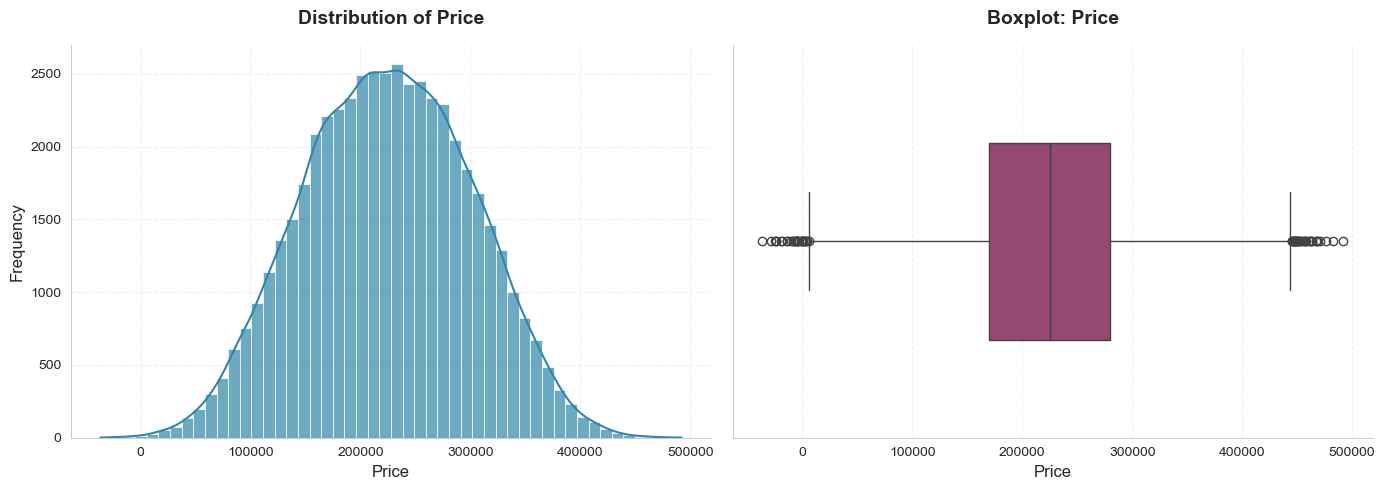

In [21]:
# Create a 1x2 subplot layout
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Set overall style
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'

# 1. Histogram + KDE (left plot)
sns.histplot(target, kde=True, bins=50, ax=axes[0], color='#2E86AB', 
             edgecolor='white', linewidth=0.5, alpha=0.7)
axes[0].set_title("Distribution of Price", fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel("Price", fontsize=12, fontweight='500')
axes[0].set_ylabel("Frequency", fontsize=12, fontweight='500')
axes[0].grid(alpha=0.3, linestyle='--')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# 2. Boxplot (right plot)
box = sns.boxplot(x=target, ax=axes[1], color='#A23B72', width=0.5)
axes[1].set_title("Boxplot: Price", fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel("Price", fontsize=12, fontweight='500')
axes[1].grid(alpha=0.3, linestyle='--', axis='x')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

The distribution of price is approximately normal, with the mean and median being nearly identical. This is confirmed by the skewness score of `-0.0083` (near zero). However, the minimum value is `-36,588`, which is impossible in the context of house prices. These examples would be treated as errors and removed to prevent model bias.

In [27]:
# Check how many rows are affected
print(df[df['Price'] <= 0].shape)

(22, 6)


In [29]:
# Remove examples with negative entries 
df_clean = df[df['Price'] > 0].copy()

## Feature Analysis 
### Numerical Features 

In [52]:
# select Numerical Features 
selected_features = ["SquareFeet", "YearBuilt"]

#calculate summary stats
summary_stats_df = df_clean[selected_features].agg(
    ['mean', 'median', 'std', 'min', 'max', 'skew', 'kurt']
).transpose() # .T flips it so metrics are columns

# 3. Clean up the naming for display 
summary_stats_df.rename(columns={'kurt': 'Kurtosis'}, inplace=True)

print("\n Summary Stats for Continuous Features:\n")
display(summary_stats_df)


 Summary Stats for Continuous Features:



,mean,median,std,min,max,skew,Kurtosis
SquareFeet,2006.752551,2008.0,575.350298,1000.0,2999.0,-0.011576,-1.189532
YearBuilt,1985.404338,1985.0,20.718407,1950.0,2021.0,0.005585,-1.196774


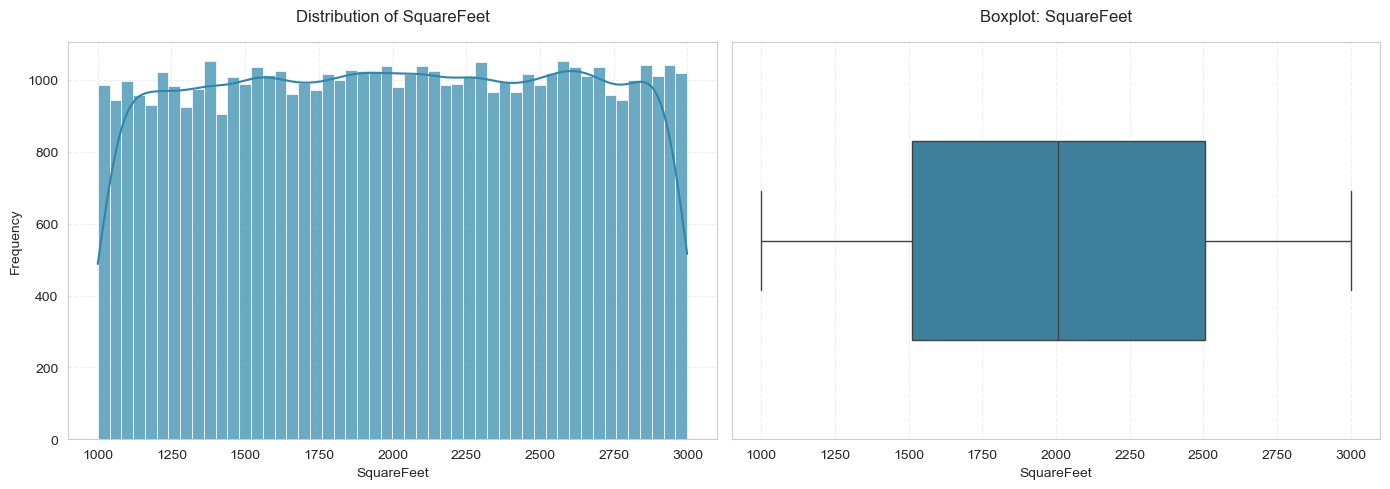

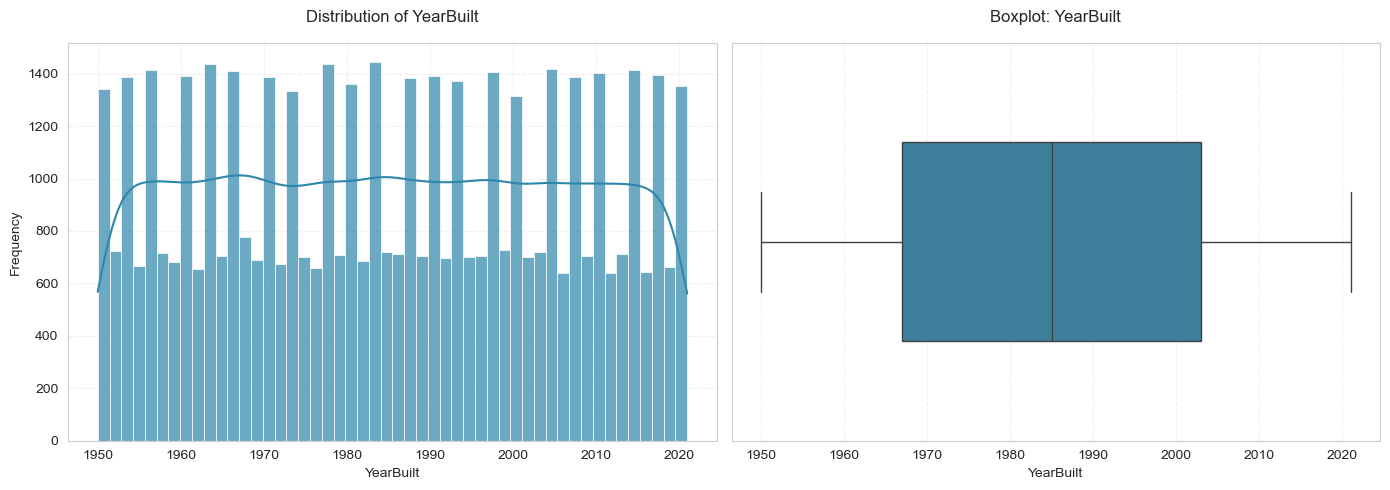

In [54]:
# Histograms + KDE & Boxplots
for col in selected_features:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Histogram + KDE (left plot)
    sns.histplot(df[col], kde=True, bins=50, ax=axes[0], color='#2E86AB',
                 edgecolor='white', linewidth=0.5, alpha=0.7)
    axes[0].set_title(f"Distribution of {col}", pad=15)
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("Frequency")
    axes[0].grid(alpha=0.3, linestyle='--')

    # Boxplot (right plot)
    sns.boxplot(x=df[col], ax=axes[1], color='#2E86AB', width=0.5)
    axes[1].set_title(f"Boxplot: {col}", pad=15)
    axes[1].set_xlabel(col)
    axes[1].grid(alpha=0.3, linestyle='--', axis='x')

    plt.tight_layout()
    plt.show()

Both continuous features, SquareFeet and YearBuilt, exhibit uniform (flat) distributions across their respective ranges (1,000–3,000 sq. ft. and 1950–2021). This indicates that the dataset contains a consistent number of properties at nearly every size and age point, with no significant skew.

To prepare these variables for the modeling pipeline:

- SquareFeet will be normalized using StandardScaler to manage its magnitude without distorting the distribution.

- YearBuilt will be transformed into a new feature, HouseAge. This conversion allows the model to interpret the linear effect of a property's age on its value more effectively than raw calendar years.

### Categorical and Discrete Features

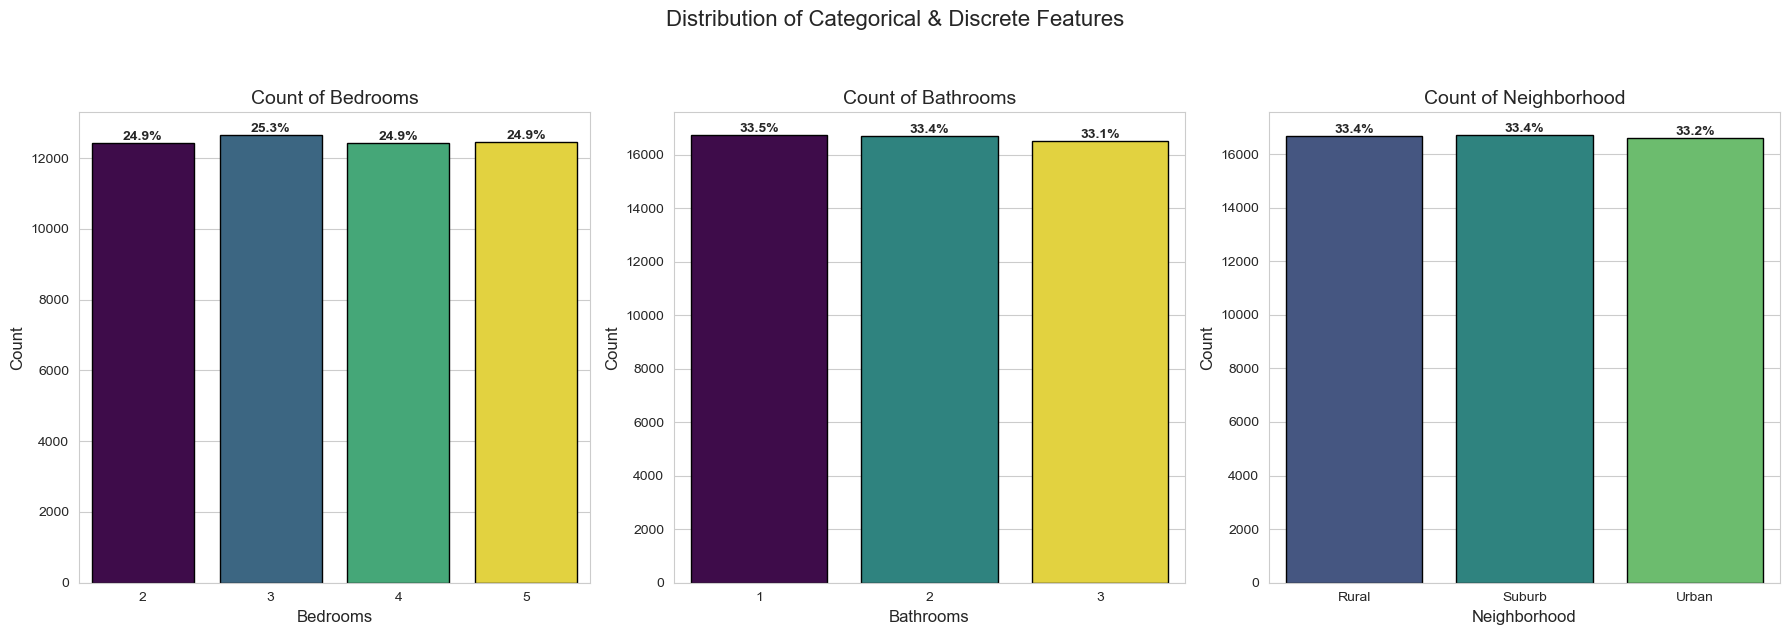

In [59]:

# Define the variables to plot
categorical_features = ["Bedrooms", "Bathrooms", "Neighborhood"]

# 2. Set up the figure grid
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Distribution of Categorical & Discrete Features', fontsize=16, y=1.05)

# 3. Loop through features
for i, col in enumerate(categorical_features):
    ax = sns.countplot(
        data=df_clean, 
        x=col, 
        hue=col,  # Assign color to the variable itself
        legend=False,
        ax=axes[i], 
        palette="viridis", 
        edgecolor="black"
    )
    
    # Customize the subplot
    axes[i].set_title(f'Count of {col}', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
    
    # 4. Add Percentage Annotations
    total = len(df_clean)
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            percentage = f'{100 * height / total:.1f}%'
            x = p.get_x() + p.get_width() / 2
            y = height
            ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


The categorical and discrete variables exhibit a perfectly uniform distribution, with each subgroup equally represented across the dataset. This precise balance strongly suggests that the data is either synthetically generated or has been explicitly stratified to ensure equal class representation

### Bivariate Analysis

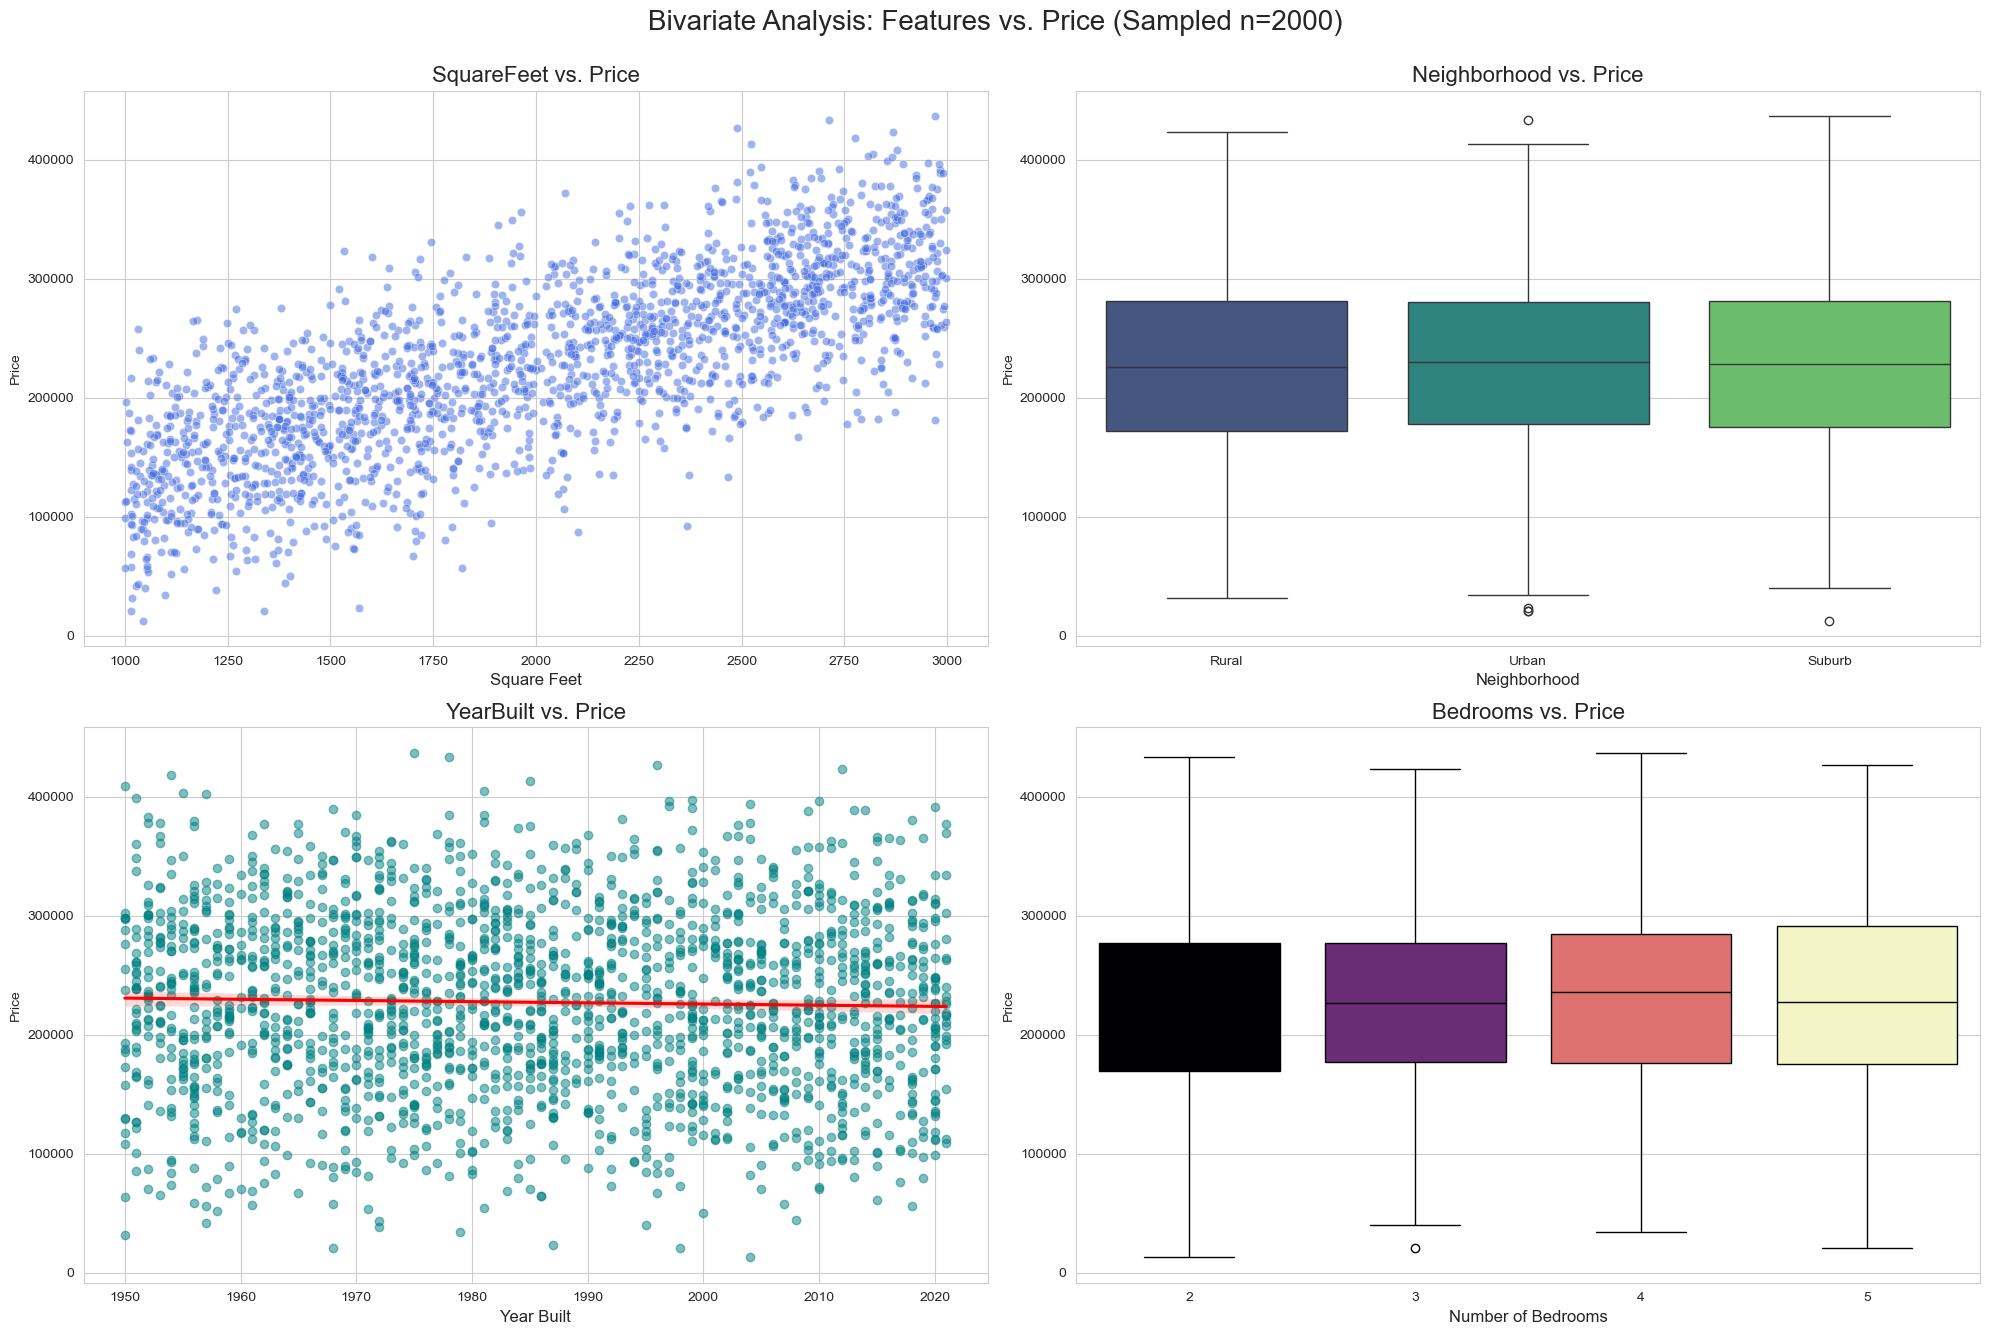

In [69]:
#  Sample the data to avoid overplotting
sample_df = df_clean.sample(n=2000, random_state=42)

# Set up the figure grid (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
fig.suptitle('Bivariate Analysis: Features vs. Price (Sampled n=2000)', fontsize=20, y=0.95)

#  Plot 1: SquareFeet vs Price (Scatter) 
sns.scatterplot(
    data=sample_df, x='SquareFeet', y='Price', 
    ax=axes[0, 0], alpha=0.5, color='royalblue'
)
axes[0, 0].set_title('SquareFeet vs. Price', fontsize=16)
axes[0, 0].set_xlabel('Square Feet', fontsize=12)

#  Plot 2: Neighborhood vs Price (Box Plot) 
# Goal: Check if location shifts the median price
sns.boxplot(
    data=sample_df, x='Neighborhood', y='Price', 
    ax=axes[0, 1], palette='viridis', hue='Neighborhood', legend=False
)
axes[0, 1].set_title('Neighborhood vs. Price', fontsize=16)
axes[0, 1].set_xlabel('Neighborhood', fontsize=12)

# Plot 3: YearBuilt vs Price (Scatter with Trend Line) 
# Goal: Check if newer houses are more expensive
# We use regplot here to draw a regression line to help spot the trend automatically
sns.regplot(
    data=sample_df, x='YearBuilt', y='Price', 
    ax=axes[1, 0], scatter_kws={'alpha':0.5, 'color':'teal'}, line_kws={'color':'red'}
)
axes[1, 0].set_title('YearBuilt vs. Price', fontsize=16)
axes[1, 0].set_xlabel('Year Built', fontsize=12)

#  Plot 4: Bedrooms vs Price (Box Plot) 
# Goal: Check if adding rooms actually adds value
sns.boxplot(
    data=sample_df, x='Bedrooms', y='Price', 
    ax=axes[1, 1], palette='magma', hue='Bedrooms', legend=False
)
axes[1, 1].set_title('Bedrooms vs. Price', fontsize=16)
axes[1, 1].set_xlabel('Number of Bedrooms', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

Visual inspection reveals that SquareFeet is the sole driver of price in this dataset, showing a clear linear trend. Conversely, YearBuilt, Neighborhood, and Bedrooms display flat trends with no discernable impact on the target variable. Specifically, neighborhood median prices are uniform, and newer homes do not command a premium over older ones. This suggests the dataset is synthetic, with price modeled almost exclusively on square footage

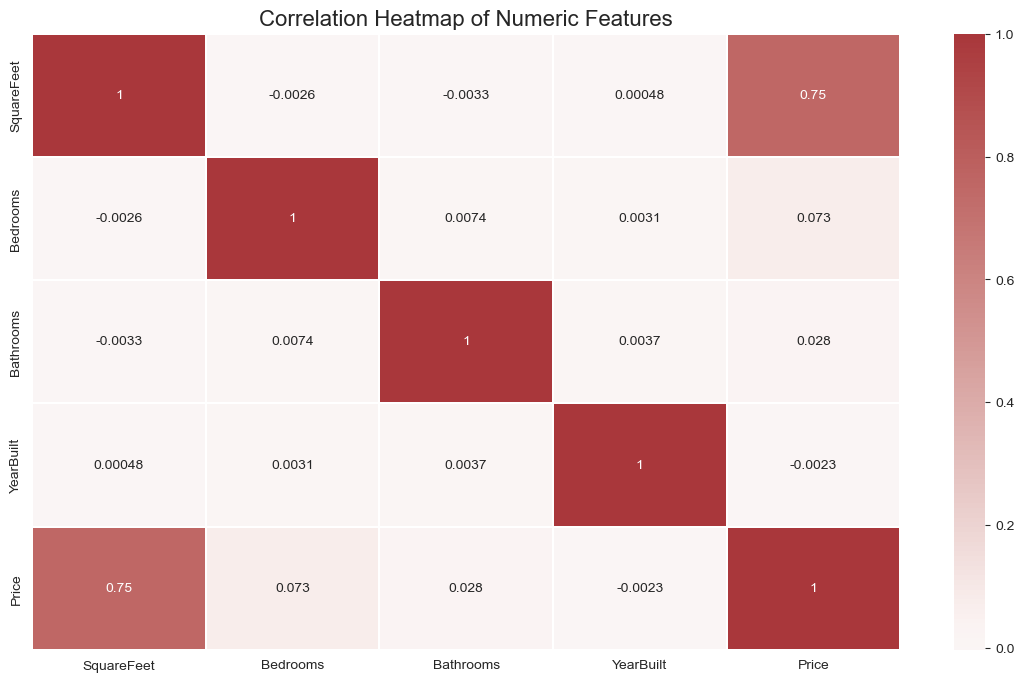

In [73]:
# plot a correlation heatmap 
numeric_df = df.select_dtypes(include=['number'])
# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    corr_matrix,
    annot=True,          # Disable numbers for clarity; enable if needed
    cmap="vlag",
    center=0,
    linewidths=0.3
)

plt.title("Correlation Heatmap of Numeric Features", fontsize=16)
plt.show()


As anticipated, SquareFeet emerges as the dominant predictor, exhibiting a strong positive correlation with Price ($r=0.75$). Conversely, Bedrooms and Bathrooms show negligible correlations, reinforcing the finding that room count alone does not dictate property value. Furthermore, the correlation matrix reveals that the features are largely independent of one another (no multicollinearity), indicating that property size and room count are uncorrelated in this dataset.